In [48]:
data_bucket = 'amazon-sagemaker-in-practice-workshop.pattern-match.com'

output_bucket = 'YOUR_USER_BUCKET_NAME_GOES_HERE'

path = 'criteo-display-ad-challenge'
key = 'sample.csv'

data_location = 's3://{}/{}/{}'.format(bucket, path, key)

In [49]:
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

print(role)

arn:aws:iam::450349639042:role/service-role/AmazonSageMaker-ExecutionRole-20180923T131486


In [21]:
import numpy as np                                    # For matrix operations and numerical processing
import pandas as pd                                   # For munging tabular data
import matplotlib.pyplot as plt                       # For charts and visualizations

from IPython.display import Image                     # For displaying images in the notebook
from IPython.display import display                   # For displaying outputs in the notebook

from time import gmtime, strftime                     # For labeling SageMaker models, endpoints, etc.

import sys                                            # For writing outputs to notebook
import math                                           # For ceiling function
import json                                           # For parsing hosting outputs
import os                                             # For manipulating filepath names

import sagemaker                                      # Amazon SageMaker's Python SDK provides helper functions
from sagemaker.predictor import csv_serializer        # Converts strings for HTTP POST requests on inference

# Data

The training dataset consists of a portion of Criteo's traffic over a period
of 7 days. Each row corresponds to a display ad served by Criteo and the first
column is indicates whether this ad has been clicked or not.
The positive (clicked) and negatives (non-clicked) examples have both been
subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26
categorical features. The values of the categorical features have been hashed
onto 32 bits for anonymization purposes. 
The semantic of these features is undisclosed. Some features may have missing values.

The rows are chronologically ordered.

The test set is computed in the same way as the training set but it 
corresponds to events on the day following the training period. 
The first column (label) has been removed.

### Format

The columns are tab separeted with the following schema:

```
<label> <integer feature 1> ... <integer feature 13> <categorical feature 1> ... <categorical feature 26>
```

When a value is missing, the field is just empty.
There is no label field in the test set.

Sample dataset contains 100 000 random rows taken from a train dataset to ease the exploration. 

In [41]:
data = pd.read_csv(data_location, header = None, sep = '\t')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page

col_0,% observations
14,
010e5266,0.00001
0121ecd4,0.00001
015405ad,0.00001
024d3a13,0.00001
0434607f,0.00001
0550a183,0.00001
05930803,0.00001
05c26cc9,0.00001
05db9164,0.50197


col_0,% observations
15,
00ac063c,0.00137
014e4174,0.00014
016cbb4f,0.00029
01d108a8,0.00002
023a27f8,0.00020
028bd518,0.00148
0363d860,0.00011
04440d29,0.00006
0468d672,0.01392


col_0,% observations
16,
0001a04d,0.00001
00044cea,0.00001
0004e357,0.00001
0005507d,0.00001
0005dfa4,0.00001
00064e30,0.00001
000651da,0.00001
00096813,0.00001
000af63e,0.00001


col_0,% observations
17,
00044baa,0.000010
00057907,0.000010
00066e71,0.000031
0017faab,0.000010
0018ef5d,0.000010
001cfd57,0.000104
00200284,0.000010
0021a09d,0.000010
0024648b,0.000031


col_0,% observations
18,
01f8694b,0.00001
03bb248f,0.00001
048e122f,0.00002
06afddf0,0.00024
085a25d4,0.00001
08d54a57,0.00002
08da92ce,0.00007
0940bd3c,0.00002
0942e0a7,0.01313


col_0,% observations
19,
13718bbd,0.044060
3bf701e7,0.020025
3c46edb2,0.000023
6f6d9be8,0.040096
7e0ccccf,0.538150
c05778d5,0.000070
c76aecf6,0.000058
e3520422,0.000185
f1f2de2d,0.000104


col_0,% observations
20,
0008893e,0.00014
0008cf60,0.00003
0016c23d,0.00015
00239ba4,0.00068
0026c72e,0.00004
002fdf0c,0.00019
0036f8a0,0.00011
0038e65c,0.00022
003b271f,0.00001


col_0,% observations
21,
0017bc7c,0.00036
0397ef7e,0.00003
062b5529,0.02638
07a0b7e5,0.00015
084d8772,0.00002
090ae928,0.00002
093a9651,0.00008
0966b2e6,0.00001
0b153874,0.59264


col_0,% observations
22,
7cc72ec2,0.11445
a18233ea,0.00032
a73ee510,0.88523


col_0,% observations
23,
0000734a,0.00005
0007c590,0.00002
000e2f4b,0.00128
00190012,0.00001
001ca98a,0.00003
00223894,0.00003
0022e234,0.00029
00279831,0.00002
0027ed1a,0.00001


col_0,% observations
24,
000c7cb7,0.00001
0014be64,0.00025
00164ba4,0.00023
002aed7e,0.00006
0044e5ec,0.00014
004929ef,0.00029
004b5860,0.00002
0083b9dd,0.00001
008e9ce1,0.00001


col_0,% observations
25,
0001b1d7,0.000010
0001ed0c,0.000010
0004837a,0.000010
000a22f5,0.000031
000c8151,0.000062
000f82d9,0.000010
000feb81,0.000010
0012aecc,0.000010
00163d5f,0.000010


col_0,% observations
26,
00041a6d,0.00002
00045837,0.00002
001fc921,0.00010
004dc387,0.00040
00613319,0.00046
0067ac1b,0.00030
00783c5a,0.00005
0087e728,0.00004
0092602c,0.00178


col_0,% observations
27,
051219e6,0.01717
0601d3b5,0.00124
07d13a8f,0.36315
0bc7c8c2,0.00015
1adce6ef,0.15964
243a4e68,0.00118
26ac7cf4,0.00055
32813e21,0.00288
5aebfb83,0.00032


col_0,% observations
28,
000e4330,0.00001
00393dbe,0.00001
003cf364,0.00085
004dd4ed,0.00015
00631f93,0.00041
0065bb75,0.00003
007ac9f6,0.00007
007fa274,0.00018
008efb75,0.00003


col_0,% observations
29,
00041498,0.000010
000ab000,0.000010
000bd40b,0.000010
0012a4bb,0.000010
00152969,0.000010
0016a69a,0.000010
00175084,0.000010
0017fb66,0.000010
001831ff,0.000010


col_0,% observations
30,
07c540c4,0.13033
1e88c74f,0.04559
2005abd1,0.04760
27c07bd6,0.04199
3486227d,0.07548
776ce399,0.06418
8efede7f,0.04138
af5d780c,0.00001
d4bb7bd8,0.12639


col_0,% observations
31,
002c3270,0.00002
002dcfdb,0.00008
003d4f4f,0.00712
004fdf10,0.00105
005c6740,0.01735
00642729,0.00002
0066463d,0.00004
006aeba4,0.00006
00ce28f6,0.00028


col_0,% observations
32,
0022a89c,0.000068
002f1f67,0.000103
0053530c,0.001452
006156b8,0.000068
006c717e,0.000017
011754e0,0.000051
014dd558,0.000051
0181ec8d,0.000017
019a4dcd,0.000051


col_0,% observations
33,
5840adea,0.367630
a458ea53,0.324335
b1252a9d,0.308035


col_0,% observations
34,
000003e0,0.00001
00026596,0.00001
00037751,0.00001
0003db58,0.00001
000682d9,0.00001
0008fb75,0.00001
000912e8,0.00001
000bbd77,0.00001
000bd67d,0.00001


col_0,% observations
35,
28f45308,0.000163
49e825c5,0.000380
78e2e389,0.031572
8651fddb,0.000705
8ec974f4,0.040740
ad3062eb,0.522947
c0061c6d,0.021808
c9d4222a,0.380981
ccfd4002,0.000597


col_0,% observations
36,
25e3c76b,0.00019
32c7478e,0.43970
3a171ecb,0.19944
423fab69,0.11383
55dd3565,0.03029
72592995,0.00008
85d5a995,0.00320
93bad2c0,0.00988
b264a060,0.00122


col_0,% observations
37,
0000865b,0.000010
000270ae,0.000010
0004350e,0.000010
000bc36a,0.000010
00161819,0.000083
0017c793,0.000021
00212427,0.000021
0024b440,0.000010
002b81a8,0.000052


col_0,% observations
38,
001f3601,0.195647
010f6491,0.065028
07ee399f,0.000205
1575c75f,0.003161
24657b11,0.000632
2bf691b1,0.037742
33d94071,0.002682
3a6f6b59,0.003503
3d2bedd7,0.005279


col_0,% observations
39,
0002cf2e,0.000017
000592de,0.000085
00095ee6,0.000051
0015d4de,0.002905
00197e62,0.000051
001e34ee,0.000273
0029230e,0.000017
0029b6a9,0.000034
002d08ab,0.000017


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,100000.000000,55587.000000,100000.000000,80898.000000,80466.000000,9.524000e+04,74893.000000,95281.000000,99893.000000,95281.000000,55587.000000,95281.000000,22820.000000,80466.000000
mean,0.226630,3.768723,112.863730,40.744913,8.280317,1.759260e+04,139.685084,15.222090,13.574825,125.294907,0.620109,2.400269,0.937774,11.607636
std,0.418653,10.451209,401.522636,538.818822,10.836336,6.579790e+04,371.776092,65.460487,46.541593,286.415686,0.677055,4.629926,5.327668,52.044556
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,2.000000,2.280000e+02,9.000000,0.000000,2.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.000000,3.000000,8.000000,5.000000,2.213000e+03,37.000000,3.000000,8.000000,40.000000,1.000000,1.000000,0.000000,5.000000
75%,0.000000,3.000000,40.000000,23.000000,11.000000,1.020900e+04,122.000000,11.000000,20.000000,120.000000,1.000000,2.000000,1.000000,13.000000
max,1.000000,556.000000,18522.000000,65535.000000,417.000000,1.741128e+06,16290.000000,8807.000000,4677.000000,12661.000000,6.000000,104.000000,493.000000,6558.000000


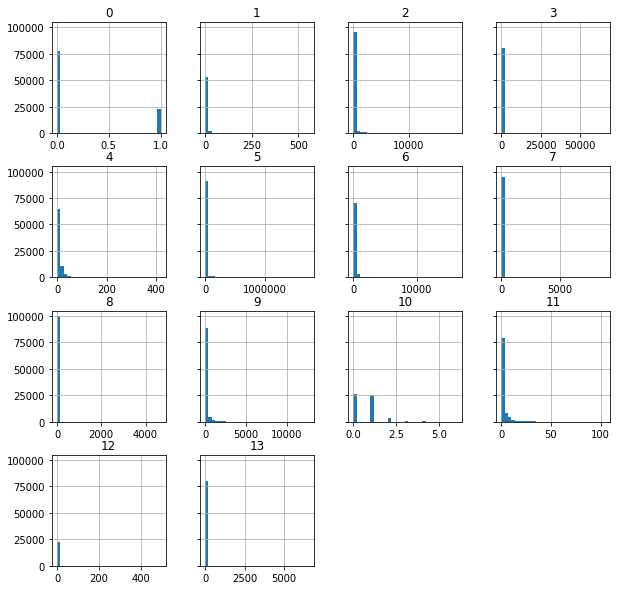

In [15]:
# Frequency tables for each categorical feature:
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index = data[column], columns = '% observations', normalize = 'columns'))

# Histograms for each numeric features:
display(data.describe())
%matplotlib inline
hist = data.hist(bins = 30, sharey = True, figsize=(10, 10))

**TODO**: Conclusions from histograms and frequency tables posted above.

**TODO**: Describing OHE and why we need it here.

In [39]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

MemoryError: 

In [40]:
# OHE for categorical columns (by default for all those with dtype 'object', so for us for 26 columns).
# Also, we should use sparse representation as it is more friendly for memory.

model_data = pd.get_dummies(data, sparse = True)

In [45]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%.

model_data_len = len(model_data)
sampled_data = model_data.sample(frac = 1, random_state = 1729)
train_data, validation_data, test_data = np.split(sampled_data, [ int(0.7 * model_data_len), int(0.9 * model_data_len) ])

In [ ]:
train_data.to_csv('train.sample.csv', index = False, header = False)
validation_data.to_csv('validation.sample.csv', index = False, header = False)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(path, 'train/train.csv')).upload_file('train.sample.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(path, 'validation/validation.csv')).upload_file('validation.sample.csv')

# Train

In [46]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data = 's3://{}/{}/train'.format(bucket, path), content_type = 'csv')
s3_input_validation = sagemaker.s3_input(s3_data = 's3://{}/{}/validation/'.format(bucket, path), content_type = 'csv')

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, path),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

# Hosting


In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Evaluation

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [ ]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).as_matrix())

In [ ]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

# Clean-up

In [47]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

NameError: name 'xgb_predictor' is not defined